In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
tweets = pd.read_csv('tweets.csv')

In [4]:
tweets = tweets[~tweets.user_id.isna()]

tweets.loc[:,'isRT'] = tweets.text.apply(lambda x: False if pd.isna(x) else True if re.match(r'^RT @',x) else False)

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3602484 entries, 12169 to 6296493
Data columns (total 19 columns):
Unnamed: 0             int64
id                     float64
text                   object
user_id                float64
in_reply_to_user_id    object
retweeted_status_id    object
retweet_count          float64
reply_count            float64
favorite_count         float64
num_hashtags           float64
num_urls               float64
num_mentions           float64
created_at             object
timestamp              object
crawled_at             object
updated                object
Cat                    object
bot                    object
isRT                   bool
dtypes: bool(1), float64(8), int64(1), object(9)
memory usage: 525.6+ MB


In [9]:
#tweets_humans = tweets[tweets.Cat=='Humans']
#display(tweets_humans.columns)

#first = True
def getTimes(times):
    if(len(times) == 0):
        return np.array([0,0,0,0])
    return np.array([times.median().seconds, times.std().seconds, times.quantile(0.25).seconds, times.quantile(0.75).seconds])

def getDist(var):
    if(len(var) == 0):
        return np.array([0,0,0,0])
    return np.array([var.median(), var.std(), var.quantile(0.25), var.quantile(0.75)])

def getDataTweets(twU):
    twU = twU.sort_values(by='timestamp', ascending=0).fillna(0) #tweets del usuario
    dates = pd.to_datetime(twU.timestamp) #aca lo que hago es guardar la columnoa como datetime

    twU.loc[:,'dayOfWeek'] = dates.dt.dayofweek # dia de la semana
    twU.loc[:,'hour'] = dates.dt.hour #hora del tweet
    twU.loc[:,'weekNum'] = dates.apply(lambda x: str(x.week) + '-' + str(x.year))

    tweetsUser = twU[twU.isRT==False] #tweets propios del usuario
    tweetsRT = twU[twU.isRT==True] #retweets

    twU.loc[:,'interval'] = pd.to_datetime(twU.timestamp.shift(1)) - pd.to_datetime(twU.timestamp)
    times = pd.to_datetime(twU.timestamp.shift(1)) - pd.to_datetime(twU.timestamp) # calculo distancia entre tweets

    tweetsUser.loc[:,'interval'] = pd.to_datetime(tweetsUser.timestamp.shift(1)) - pd.to_datetime(tweetsUser.timestamp)
    timesUser = pd.to_datetime(tweetsUser.timestamp.shift(1)) - pd.to_datetime(tweetsUser.timestamp) # calculo distancia entre tweets

    tweetsRT.loc[:,'interval'] = pd.to_datetime(tweetsRT.timestamp.shift(1)) - pd.to_datetime(tweetsRT.timestamp)
    timesRT = pd.to_datetime(tweetsRT.timestamp.shift(1)) - pd.to_datetime(tweetsRT.timestamp) # calculo distancia entre tweets

    #ver word_to_vect
    result = np.concatenate([
        [
            twU.iloc[0].user_id,
            twU.iloc[0].bot,
            twU.iloc[0].Cat,
            twU.count(),
            len(twU.weekNum.unique())
        ],
        getTimes(times),
        getTimes(timesRT),
        getTimes(timesUser),
        getDist(tweetsUser.favorite_count) * 10000,
        getDist(tweetsUser.retweet_count) * 10000,
        getDist(tweetsUser.num_mentions) * 10000,
        getDist(tweetsUser.reply_count) * 10000,

    ])
    return result
#         display(twU.head())
    #time_median, time_std, max_cuart, min_cuart, media_lun, media_martes, dispercion_horario
    #media_palabras
    #cantidad de palabras unicas

    #cantidad_usr que retwittea / cantidad de retweets

# res = pd.concat([
#     tweets[tweets.bot==True].iloc[0:6000],
#     tweets[tweets.bot==False].iloc[0:6000]
# ]).groupby('user_id').apply(getDataTweets)

res = tweets.groupby('user_id').apply(getDataTweets)
cols = np.concatenate(
    [
        
        [x+'_mean', x+'_std', x+'_fq', x+'_tq'] for x in
        ['times','timesRT','timesUser','favorite_count','retweet_count','num_mentions','reply_count']
    ]
)
cols = np.concatenate([
    ['user_id', 'bot', 'Cat', 'tweetsCount', 'semanas'],cols
])
res = pd.DataFrame(
    [x for x in res], columns = cols
)
res.index = res.user_id

print(len(res))
display(res.head())

2183


,user_id,bot,Cat,tweetsCount,semanas,times_mean,times_std,times_fq,times_tq,timesRT_mean,...,retweet_count_fq,retweet_count_tq,num_mentions_mean,num_mentions_std,num_mentions_fq,num_mentions_tq,reply_count_mean,reply_count_std,reply_count_fq,reply_count_tq
user_id,,,,,,,,,,,,,,,,,,,,,
678033.0,678033.0,False,Humans,Unnamed: 0 3195 id ...,27,311,11434,65,2834,2082.0,...,0.0,0.0,10000.0,8720.070307,0.0,10000.0,0.0,0.0,0.0,0.0
722623.0,722623.0,False,Humans,Unnamed: 0 3201 id ...,89,5505,24954,873,20678,59960.0,...,0.0,0.0,0.0,6453.941616,0.0,10000.0,0.0,0.0,0.0,0.0
755116.0,755116.0,False,Humans,Unnamed: 0 3209 id ...,30,369,15330,90,2641,20956.0,...,0.0,0.0,10000.0,10512.287386,0.0,20000.0,0.0,0.0,0.0,0.0
755746.0,755746.0,False,Humans,Unnamed: 0 3234 id ...,91,5818,24169,733,22987,3395.0,...,0.0,0.0,10000.0,6578.193523,0.0,10000.0,0.0,0.0,0.0,0.0
785080.0,785080.0,False,Humans,Unnamed: 0 3235 id ...,23,87,14217,36,436,8727.0,...,0.0,0.0,10000.0,8842.028988,0.0,10000.0,0.0,0.0,0.0,0.0


In [86]:
display(res.head())
print(res.columns)

,user_id,bot,Cat,tweetsCount,semanas,times_mean,times_std,times_fq,times_tq,timesRT_mean,...,retweet_count_fq,retweet_count_tq,num_mentions_mean,num_mentions_std,num_mentions_fq,num_mentions_tq,reply_count_mean,reply_count_std,reply_count_fq,reply_count_tq
user_id,,,,,,,,,,,,,,,,,,,,,
678033.0,678033.0,False,Humans,Unnamed: 0 3195 id ...,27,311,11434,65,2834,2082.0,...,0.0,0.0,10000.0,8720.070307,0.0,10000.0,0.0,0.0,0.0,0.0
722623.0,722623.0,False,Humans,Unnamed: 0 3201 id ...,89,5505,24954,873,20678,59960.0,...,0.0,0.0,0.0,6453.941616,0.0,10000.0,0.0,0.0,0.0,0.0
755116.0,755116.0,False,Humans,Unnamed: 0 3209 id ...,30,369,15330,90,2641,20956.0,...,0.0,0.0,10000.0,10512.287386,0.0,20000.0,0.0,0.0,0.0,0.0
755746.0,755746.0,False,Humans,Unnamed: 0 3234 id ...,91,5818,24169,733,22987,3395.0,...,0.0,0.0,10000.0,6578.193523,0.0,10000.0,0.0,0.0,0.0,0.0
785080.0,785080.0,False,Humans,Unnamed: 0 3235 id ...,23,87,14217,36,436,8727.0,...,0.0,0.0,10000.0,8842.028988,0.0,10000.0,0.0,0.0,0.0,0.0


Index(['user_id', 'bot', 'Cat', 'tweetsCount', 'semanas', 'times_mean',
       'times_std', 'times_fq', 'times_tq', 'timesRT_mean', 'timesRT_std',
       'timesRT_fq', 'timesRT_tq', 'timesUser_mean', 'timesUser_std',
       'timesUser_fq', 'timesUser_tq', 'favorite_count_mean',
       'favorite_count_std', 'favorite_count_fq', 'favorite_count_tq',
       'retweet_count_mean', 'retweet_count_std', 'retweet_count_fq',
       'retweet_count_tq', 'num_mentions_mean', 'num_mentions_std',
       'num_mentions_fq', 'num_mentions_tq', 'reply_count_mean',
       'reply_count_std', 'reply_count_fq', 'reply_count_tq'],
      dtype='object')


[(0, 15000)]

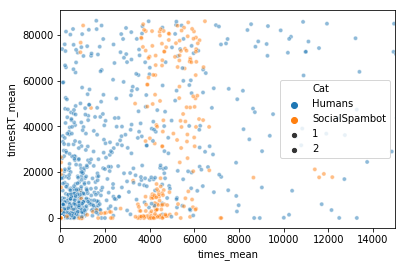

In [22]:
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


# sns.pairplot(res[['times_mean','timesRT_mean','Cat']], hue='Cat', diag_kind="kde")


g = sns.scatterplot(x="times_mean", y="timesRT_mean", hue='Cat', data=res, alpha=0.5, size=2)

g.set(xlim=(0, 15000))

Text(0.5,0,'timesUser_tq')

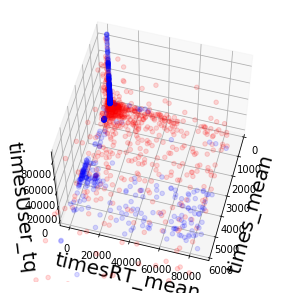

In [31]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
colors = {'Humans':'red', 'SocialSpambot':'blue'}
ax.scatter3D(res.times_mean, res.timesRT_mean, res.timesUser_tq, c=res['Cat'].apply(lambda x: colors[x]), alpha=0.15);
ax.view_init(60, 15)

ax.set_xlim([0, 6000])
# ax.set_zlim([0, 150])

ax.set_xlabel('times_mean', fontsize=20)
ax.set_ylabel('timesRT_mean', fontsize=20)
ax.set_zlabel('timesUser_tq', fontsize=20)

In [82]:

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.__version__

init_notebook_mode(connected=True)

colors = {'Humans':'red', 'SocialSpambot':'blue'}

trace1 = go.Scatter3d(
    x=res.times_mean,
    y=res.timesRT_mean,
    z=res.timesUser_tq,
    mode='markers',
    marker=dict(
        size=5,
        color=res['Cat'].apply(lambda x: colors[x]),
        line=dict(
            color='rgba(255,255,255,0.2)',
            width=0
        ),
        opacity=0.3
    )
)
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene = dict(
        xaxis = dict(
            nticks=4,
            range = [0,10000],
            title='times median',
        ),
        yaxis = dict(
            title='timesRT_mean',
        ),
        zaxis = dict(
            title='timesUser_tq',
        ),
    )
)
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

In [84]:
colors = {'Humans':'red', 'SocialSpambot':'blue'}

trace1 = go.Scatter3d(
    x=res.times_mean,
    y=res.timesRT_mean,
    z=res.timesUser_fq,
    mode='markers',
    marker=dict(
        size=5,
        color=res['Cat'].apply(lambda x: colors[x]),
        line=dict(
            color='rgba(255,255,255,0.2)',
            width=0
        ),
        opacity=0.4
    )
)
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene = dict(
        xaxis = dict(
            nticks=4,
            range = [0,10000],
            title='times median',
        ),
        yaxis = dict(
            title='timesRT_mean',
        ),
        zaxis = dict(
            range = [0,2000],
            title='timesUser_fq',
        ),
    )
)
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

ValueError: setting an array element with a sequence.

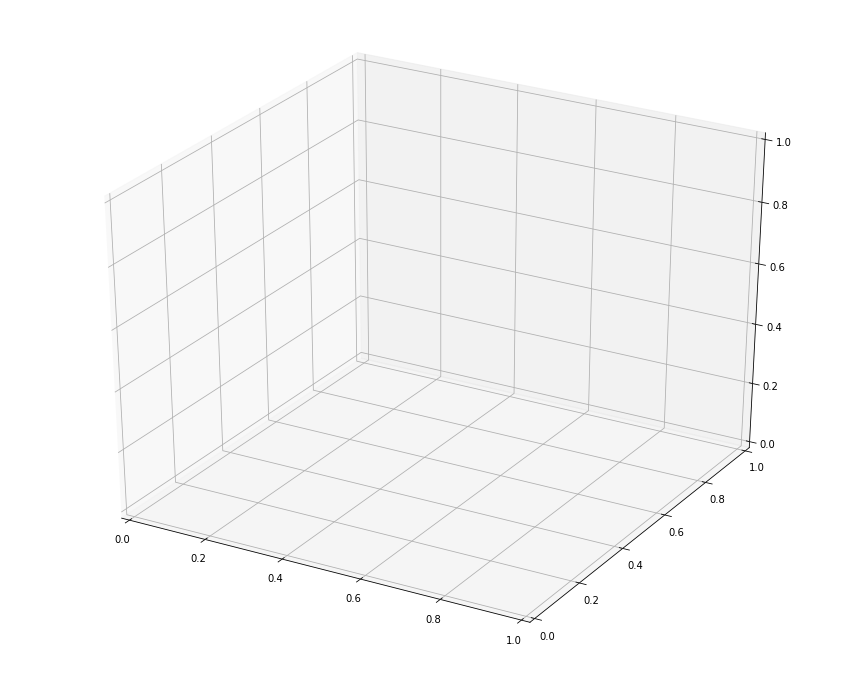

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

colors = {'Humans':'red', 'SocialSpambot':'blue'}

ax.scatter3D(res.times_mean, res.tweetsCount, res.timesRT_mean, c=res['Cat'].apply(lambda x: colors[x]), alpha=0.25);
ax.view_init(60, 15)

ax.set_xlim([0, 6000])

# ax.set_zlim([0, 40000])


ax.set_xlabel('times_mean', fontsize=20)
ax.set_ylabel('tweetsCount', fontsize=20)
ax.set_zlabel('timesRT_mean', fontsize=20)

# g = sns.scatterplot(x="times_mean", y="tweetsCount", hue='Cat', data=res, alpha=0.5)
# g.set(xlim=(0, 20000))

Text(0.5,0,'semanas')

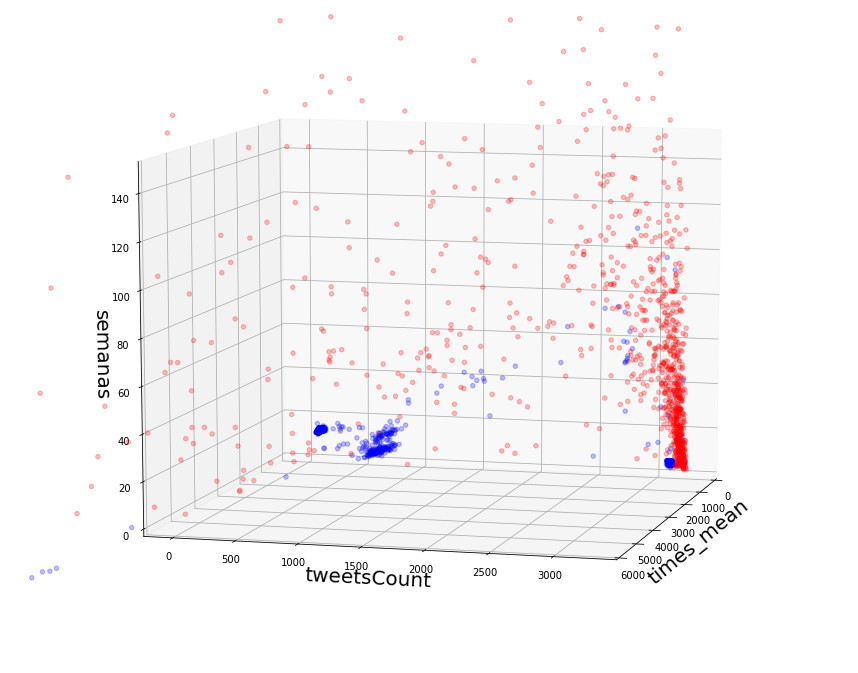

In [178]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
colors = {'Humans':'red', 'SocialSpambot':'blue'}
ax.scatter3D(res.times_mean, res.tweetsCount, res.semanas, c=res['Cat'].apply(lambda x: colors[x]), alpha=0.25);
ax.view_init(10, 15)

ax.set_xlim([0, 6000])
ax.set_zlim([0, 150])

ax.set_xlabel('times_mean', fontsize=20)
ax.set_ylabel('tweetsCount', fontsize=20)
ax.set_zlabel('semanas', fontsize=20)